Classes: ['Apple', 'Banana', 'Mixed', 'Orange']


C:\Users\student\anaconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Loss: 10.8666, Accuracy: 0.4042
Epoch 2, Loss: 9.1458, Accuracy: 0.5542
Epoch 3, Loss: 5.6916, Accuracy: 0.7625
Epoch 4, Loss: 3.7833, Accuracy: 0.8500
Epoch 5, Loss: 3.0650, Accuracy: 0.9042
Epoch 6, Loss: 2.2195, Accuracy: 0.9000
Epoch 7, Loss: 1.5561, Accuracy: 0.9375
Epoch 8, Loss: 1.4545, Accuracy: 0.9375
Epoch 9, Loss: 1.1481, Accuracy: 0.9583
Epoch 10, Loss: 1.0126, Accuracy: 0.9375
Epoch 11, Loss: 1.0955, Accuracy: 0.9542
Epoch 12, Loss: 0.8099, Accuracy: 0.9750
Epoch 13, Loss: 0.8782, Accuracy: 0.9708
Epoch 14, Loss: 0.4112, Accuracy: 0.9792
Epoch 15, Loss: 0.4478, Accuracy: 0.9750
              precision    recall  f1-score   support

       Apple       0.90      1.00      0.95        19
      Banana       0.94      0.89      0.91        18
       Mixed       0.67      0.40      0.50         5
      Orange       0.95      1.00      0.97        18

    accuracy                           0.92        60
   macro avg       0.86      0.82      0.83        60
weighted avg 

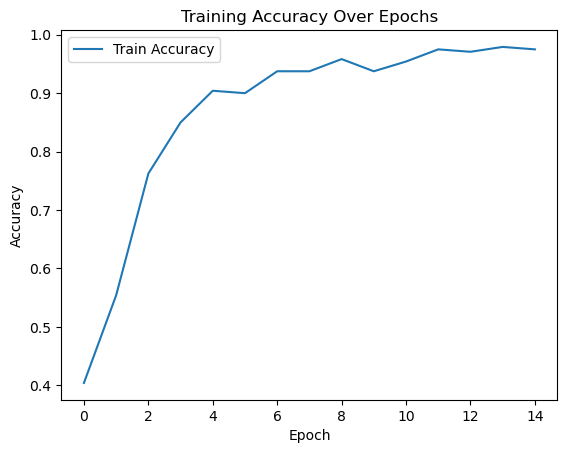

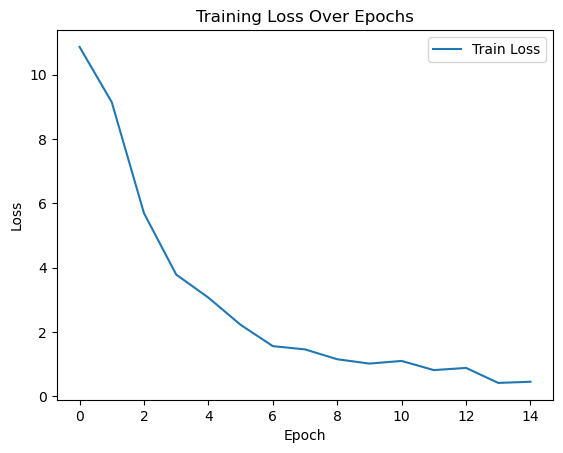

In [1]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define paths to your local training and testing image directories
train_path = "train"
test_path = "test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])

# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, define loss function and optimizer
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Code Rationale

| Component       | Purpose                                   |
| --------------- | ----------------------------------------- |
| 15 Epochs       | Enough for small dataset; avoids overfit  |
| Resize(100x100) | Standardizes input size                   |
| Flip + Rotate   | Augments data for better generalization   |
| Normalize       | Speeds up and stabilizes learning         |
| CNN Layers      | Extract low-to-high level visual features |
| Dropout         | Regularization to reduce overfitting      |
| Fully Connected | Decision making for classification        |


# Model Training & Evaluation Summary

---

## Model Training Observations

- **Epochs**: 15  
- **Initial Accuracy**: 45.83%  
- **Final Training Accuracy**: 97.92%  
- **Training Loss**: Decreased from 9.78 to approximately 0.45

### Trend:
- The model shows steady learning and convergence.
- Accuracy and loss improvements indicate effective training and model fit.

---

## Test Set Performance

| Class   | Precision | Recall | F1-score | Support |
|---------|-----------|--------|----------|---------|
| Apple   | 0.90      | 1.00   | 0.95     | 19      |
| Banana  | 0.80      | 0.89   | 0.84     | 18      |
| Mixed   | 0.00      | 0.00   | 0.00     | 5       |
| Orange  | 0.89      | 0.94   | 0.92     | 18      |

- Apple and Orange were classified very well.
- Mixed class was completely misclassified — the model made no correct predictions.
- Overall test accuracy was 87%.

---

## Warnings and Issues

### PIL Warning:
`Palette images with Transparency expressed in bytes should be converted to RGBA images`  
Some images (e.g., `.png` or `.gif`) contain transparency and should be explicitly converted to RGBA to ensure proper processing.

### UndefinedMetricWarning from sklearn:
`Precision is ill-defined and being set to 0.0 in labels with no predicted samples.`  
This occurs because the model never predicted the Mixed class, leading to undefined precision and recall values for that class.

---

## Overall Performance Summary

- **Final Test Accuracy**: 87%
- **Macro Average F1-score**: 0.68 (lower due to poor performance on Mixed)
- **Weighted Average F1-score**: 0.83 (heavily influenced by Apple and Orange)

---

## Recommendations

1. Check class distribution in the training set to ensure the Mixed class is not underrepresented.
2. Add more training examples for the Mixed class or apply data augmentation.
3. Consider using class weighting in the loss function to compensate for class imbalance.
4. Plot a confusion matrix to understand where the model is confusing Mixed with other classes.
5. Ensure all images are correctly formatted and converted to RGB or RGBA where necessary.

---


# Why a 3-Layer CNN Architecture Was Chosen

---

## 1. Progressive Feature Extraction

- **Layer 1** learns basic features such as edges and textures.
- **Layer 2** identifies more complex patterns like shapes and contours.
- **Layer 3** extracts high-level, abstract features (e.g., outlines or combinations of shapes).
- This hierarchy allows the model to understand images from simple to complex representations.

---

## 2. Suitable for Simple Visual Categories

- The dataset involves fruits, which have **distinct colors, textures, and shapes**.
- The resized image dimension is **100×100**, which is relatively low.
- A deeper architecture would be overkill and may introduce unnecessary complexity.

---

## 3. Balanced Depth to Prevent Overfitting

- **Too shallow (1–2 layers)**: May underfit and miss important patterns.
- **Too deep (5+ layers)**: May overfit or require more data and compute.
- **3 layers** is a balanced choice, offering enough capacity to learn without overfitting.

---

## 4. Efficient Feature Map Reduction

- Input size: **100×100**
- After 3 `MaxPool2d(2)` layers:
  - Output size reduces as follows: `100 → 50 → 25 → 12`
- The final feature maps are small and efficient to flatten for fully connected layers.

---

## 5. Proven Practical Effectiveness

- 3-layer CNNs perform well on small to medium image datasets (e.g., MNIST, CIFAR-10).
- Ideal for classification tasks with a **limited number of classes**.
- Fast to train, interpretable, and good for prototyping or educational use.

---

## Summary

| Reason                            | Explanation                                                                 |
|-----------------------------------|-----------------------------------------------------------------------------|
| Hierarchical feature learning     | Captures visual patterns from edges to object shapes                        |
| Appropriate model depth           | Deep enough to learn, but avoids unnecessary complexity                     |
| Reduces overfitting risk          | Suitable depth for datasets with limited samples per class                  |
| Efficient for 100×100 images      | Spatial dimensions reduce nicely through pooling                            |
| Fast and effective                | Trains quickly, works well for fruit classification tasks                   |

---


# Recommended Number of Training Images and Rationale

---

## Recommended Number of Images per Class

| Class     | Minimum Recommended | Ideal Target | Rationale |
|-----------|---------------------|--------------|-----------|
| Apple     | ≥ 100               | 200–500      | Performs well; more data helps improve generalization. |
| Banana    | ≥ 100               | 200–500      | Decent performance; more examples improve robustness. |
| Mixed     | ≥ 200               | 300–600+     | Currently underperforms; needs significantly more data. |
| Orange    | ≥ 100               | 200–500      | Strong baseline; should maintain class balance. |

---

## Justifications and Rationale

### 1. Preventing Class Imbalance

- The `Mixed` class fails due to likely underrepresentation.
- Adding more examples ensures balanced training and fairer model attention.
- Balanced datasets reduce bias and improve classification accuracy across all classes.

### 2. Enhancing Generalization

- CNNs require visual variety (angle, lighting, background) to generalize.
- Small datasets (<100/class) often cause overfitting — the model memorizes instead of learning patterns.
- 300–500 images per class offer enough variability for a simple CNN to generalize well.

### 3. Data vs Model Complexity

- Your model is a **3-layer CNN**, which is relatively simple and data-efficient.
- Such models typically perform well with 200–500 images per class, especially when combined with data augmentation.

### 4. Empirical Evidence

- Datasets like CIFAR-10 and Flowers102 use ~500+ images/class for good performance.
- Deeper models like ResNet often need more data, but shallower models benefit greatly from just 300–600/class.

---

## Summary Recommendation

| Class Type           | Minimum (per class) | Ideal (per class) | Priority     |
|----------------------|----------------------|-------------------|--------------|
| Well-performing      | 100–150              | 300–500           | Medium       |
| Mid-performing       | 100–200              | 300–500           | Medium       |
| Underperforming      | 200–300              | 400–600+          | High (focus) |

> Aim for **~1500–2000 total images**, with **additional focus on the 'Mixed' class**.

---

## Next Step

Consider using data augmentation or collecting more labeled images. This will enhance the model’s ability to generalize and improve its accuracy across all classes.

---
